In [1]:
from optparse import OptionParser

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#from ipykernel import kernelapp as app

In [2]:
np.set_printoptions(precision=8, suppress=1)

## Define Grid

In [3]:
class Grid:
    def __init__(self, x):
        self.x = x
        self.dx = x[1] - x[0]
        self.n = len(x)

    def zeros(self, shape=(), dtype=float):
        return np.zeros((self.n,) + shape, dtype=dtype)

    def int(self, a_x, axis=0):
        return a_x.sum(axis=axis) * self.dx

    def norm2(self, psi_x, axis=0):
        return self.int(psi_x**2, axis=axis)

    def norm(self, psi_x, axis=0):
        return np.sqrt(self.norm2(psi_x, axis=axis))

    def normalize(self, psi_x, axis=0):
        raise NotImplementedError
        shapeoffset = (np.array(psi_x.shape) + axis) % len(psi_x.shape)
        psi_ay = psi_x.transpose(*shapeoffset)
        psi_ay /= self.norm(psi_ay, axis=0)[None, ...]
        
class RadialGrid(Grid):
    def __init__(self, x):
        if (x <= 0).any():
            raise ValueError('Negative radial coordinates')
        Grid.__init__(self, x)


## Poisson Solver

In [4]:
class SoftCoulombPoisson:
    def __init__(self, grid, softness=1.0):
        self.grid = grid
        self.softness = softness

    def solve(self, n_g):
        grid = self.grid
        softness = self.softness
        v_g = grid.zeros(dtype=n_g.dtype)
        x = grid.x
        for i, xp in enumerate(x):
            v_g[i] = (n_g / np.sqrt((x - xp)**2 + softness)).sum()
        v_g *= grid.dx
        return v_g
    
class RadialPoisson:
    def __init__(self, grid):
        self.grid = grid
        #from gpaw.utilities import hartree
        #self.hartree = hartree

    def solve(self, n_g):
        g = self.grid
        dp = n_g * g.x * g.dx
        dq = dp * g.x
        p = np.add.accumulate(dp[::-1])[::-1]
        q = np.add.accumulate(dq[::-1])[::-1]
        v_g = 4 * np.pi * (p - 0.5 * dp - (q - 0.5 * dq - q[0]) / g.x)
        return v_g


## EigenSolver

In [5]:
class EigenSolver:
    def __init__(self, grid, nstates=None):
        self.grid = grid
        self.nstates = nstates
    
    def solve(self, H_gg):
        eps_n, psi_gn = np.linalg.eigh(H_gg)
        nstates = self.nstates
        if nstates is None:
            nstates = len(H_gg)
        eps_n = eps_n[:nstates].copy()
        psi_gn = psi_gn[:, :nstates].copy()
        norms = self.grid.norm(psi_gn, axis=0)
        psi_gn /= norms[None, :]
        return eps_n, psi_gn


class CSEigenSolver:
    def __init__(self, grid, nstates=None):
        self.grid = grid
        self.nstates = nstates

    def solve(self, H_gg):
        eps_n, psi_gn = np.linalg.eig(H_gg)
        nstates = self.nstates
        if nstates is None:
            nstates = len(H_gg)
        
        args = np.argsort(eps_n.real)
        eps_n = eps_n[args[:nstates]].copy()
        psi_gn = psi_gn[:, args[:nstates]].copy()
        normsqrs = (psi_gn**2).sum(axis=0) * self.grid.dx
        psi_gn[:, :] /= np.sqrt(normsqrs)[None, :]
        return eps_n, psi_gn


## Get Kinetic Energy

In [6]:
lstencils = [[0.],
             [-2., 1.],
             [-5./2., 4./3., -1./12.],
             [-49./18., 3./2., -3./20., 1./90.],
             [-205./72., 8./5., -1./5., 8./315., -1./560.],
             [-5269./1800., 5./3., -5./21., 5./126., -5./1008., 1./3150.],
             [-5369./1800., 12./7., -15./56., 10./189., -1./112., 2./1925.,
              -1./16632.]]

deriv_stencils = [np.array(coefs) / normalization
                  for coefs, normalization
                  in [([0.], 1.), 
                      ([0., 1.], 2.),
                      ([0., 8., -1.], 12.,),
                      ([0., 45., -9., 1.], 60.)]]

deriv_stencils = [[0.],
                  [0., 1./2.],
                  [0., 2./3., -1./12.],
                  [0., 3./4., -3./20., 1./60.],
                  [0., 4./5., -1./5., 4./105., -1./280.]]

neumann_stencil = [[0.],
                  [0., 1./2.]]


def get_derivative(x, order=1):
    dx = x[1] - x[0]
    N = len(x)

    stencil = deriv_stencils[order] / dx

    D = np.zeros((N, N))
    Dflat = D.ravel()
    for i, val in enumerate(stencil):
        Dflat[i::N + 1] = val
        Dflat[i * N::N + 1] = -val
    return D


def get_kinetic(x, order=1, periodic=False):
    N = len(x)
    dx = x[1] - x[0]
    T = np.zeros((N, N))
    Tflat = T.ravel()

    stencil = lstencils[order]

    for i, val in enumerate(stencil):
        Tflat[i::N + 1] = val
        Tflat[i * N::N + 1] = val
    if periodic:
        if order > 1:
            raise NotImplementedError
        T[-1, 0] = 1.0
        T[0, -1] = 1.0
#    T *= 1 / dx**2
    T *= 1/dx**2
    return T

def get_deriv2_neumann(x, order=1, periodic=False):
    N = len(x)
    dx = x[1] - x[0]
    T = np.zeros((N, N))
    Tflat = T.ravel()

    stencil = lstencils[order]

    for i, val in enumerate(stencil):
        Tflat[i::N + 1] = val
        Tflat[i * N::N + 1] = val
        
    T[0,1] = 2
    T[N-1,N-2] = 2
    T *= 1 / dx**2
    
#    BC = np.zeros((N,1))
#    #Here we state that both the Lboundary and Rboundary have a derivative equal to zero
#    BC[N-1] = 0
#    BC[0] = 0
#    BC *= 2/dx
    
#    T += BC

    return T


## We obtain the kinetic energy from laplacian with radial symmetry:

$$\Delta \psi = \frac{1}{r} \{  r \frac{d^2}{dr^2}  + 2 \frac{d}{dr}   \} \psi$$

In [7]:
class NoXC:
     def xc(self, n):
         return np.zeros_like(n), np.zeros_like(n)

## Initial Parameters

(0, 20)

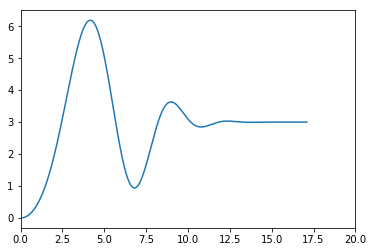

In [294]:
def phase(N):
    return np.exp(1j * N * theta)

nstates = 10
ne      = 1

cscaling = 1
#theta = np.pi / 12.0
theta = np.pi / 6.0
#theta = 0.0

dimensions = 3
gridsize = 2000


###################DIMENSION###################
if dimensions ==1:
    
    g = Grid(r)
    
    r = np.linspace(-18,10,gridsize)
    #1 Dimensional Coulomb Contribution
    poisson = SoftCoulombPoisson(g,softness=phase(-2))
    
    #1 Dimensional Kinetic Energy
    T_gg1 = get_kinetic(g.x.real,order=6) * phase(-2)
    
    

    
if dimensions ==3:
    r = np.linspace(0.1,17.1,gridsize)
    g = Grid(r)
    poisson = RadialPoisson(g)

    #Kinetic Energy for a Radially symmetric External Potential
#    deriv_second = get_deriv2_neumann(g.x.real)
    deriv_second = get_kinetic(g.x.real,order=6)
    deriv_first = get_derivative(g.x.real,order=4)

    T_gg2 = deriv_second - (1/g.x) * deriv_first
#    T_gg2 = deriv_second
#    T_gg2 = (1/g.x) * deriv_first
    T_gg = T_gg2 * phase(-2)
    T_gg *= -1/2
    
   
    
    
    
###################COMPLEX SCALING###################
if cscaling==1:
    rtheta = r *phase(1)
    eig = CSEigenSolver(g,nstates)

if cscaling==0:

    eig = EigenSolver(g,nstates)
    print("No complex scaling performed")
    

rthetasquared = rtheta * np.conj(rtheta)


##########EXTERNAL POTENTIAL#############
#What is the value that ensures a really defined bound state? Wee need to have it under the value of w. 
# w = 2.5 -> energy = 2.5
# w = 3 -> energy = 2.5
# w = 4 -> energy = 2.5
# w = 5 -> energy = 2.523
# w = 6 -> energy = 2.532
# w = 8 -> energy = 2.548

w = 3.0
#vext_g = (1/2 * rthetasquared - w) * np.exp(-0.1 * rthetasquared **2) + w
vext_g = (1/2 * rtheta**2 - w) * np.exp(-0.1 * rtheta **2) + w
#
#fig1 = plt.plot(g.x, vext_g.real)
plt.plot(g.x, vext_g.real)
plt.xlim([-0,20])
#plt.ylim([4,6])

In [295]:
#These Japanese guy second derivative approximation
#h=x[1]-x[0]
#D=-np.eye(gridsize)+np.diagflat(np.ones(gridsize-1),1)
#D = D / h

#D2=D.dot(-D.T)
#D2[-1,-1]=D2[0,0]

In [296]:
print(g.x.shape)
#print(D.shape)
#print(D2.shape)

(2000,)


## equis2 = g.x ** 2
d_equis2 = np.dot(D,equis2)
d2_equis2 = np.dot(D2,equis2)

d_e = np.dot(deriv_first, equis2)
d2_e = np.dot(get_deriv2_neumann(g.x),equis2)
d2_ee = np.dot(deriv_second,equis2)


#plt.plot(g.x,equis2)
#plt.plot(g.x,d_e)
plt.plot(g.x, d2_e)
plt.plot(g.x, d2_ee)

plt.scatter(2,4)

#plt.plot(g.x,d_equis2)
#plt.plot(g.x,d2_equis2)


plt.xlim(0,3)
plt.ylim(-2,5)

## Initialize things for the SCF cycle

In [297]:
n_g = g.zeros(dtype=complex)

f_n = np.zeros(nstates * 2)
f_n[:ne] = 1.0
f_n = f_n.reshape(-1, 2).sum(axis=-1)

mix = 0.9

xc = NoXC()

In [298]:
for i in range(40):
    v_g = vext_g
#    v_g /= np.sqrt(4 * np.pi)

    H_gg = T_gg.copy() + np.diag(vext_g)
    eps_n, psi_gn = eig.solve(H_gg)
    
    #Normalize the states:
    psi_gn /= np.sqrt(g.dx)
    
    n_prev = n_g
    n_g = (psi_gn[:, :]**2 * f_n[None, :]).sum(axis=1)
    logerr = np.log10(abs(n_prev - n_g).sum() * (g.dx / ne))

    print ('iter %4d :: logerr %f' % (i, logerr))
    if logerr < -8:
        break
    
    n_g = n_g * mix + n_prev * (1.0 - mix)
#   vH_g = poisson.solve(n_g) * phase(-1)
#    exc, vxc_g = xc.xc(n_g)

iter    0 :: logerr 2.499310
iter    1 :: logerr 1.499310
iter    2 :: logerr 0.499310
iter    3 :: logerr -0.500690
iter    4 :: logerr -1.500690
iter    5 :: logerr -2.500690
iter    6 :: logerr -3.500690
iter    7 :: logerr -4.500690
iter    8 :: logerr -5.500690
iter    9 :: logerr -6.500690
iter   10 :: logerr -7.500690
iter   11 :: logerr -8.500690


In [299]:
Ekin = (eps_n[:nstates] * f_n).sum() - g.int(v_g * n_g)
Eext = g.int(n_g * vext_g)
#Ehartree = 0.5 * g.int(n_g * vH_g)
#Exc = g.int(exc * n_g)
#Etot = Ekin + Ehartree + Eext # XC

#density = n_g / g.x**2

Etot = Ekin + Eext


In [300]:
print("Kinetic", Ekin)
print("Potential", Eext)
print("Total Energy",Etot)

Kinetic (-143.80510961523112-8.271172158405014j)
Potential (145.46250588324668+8.369908346064042j)
Total Energy (1.6573962680155603+0.09873618765902847j)


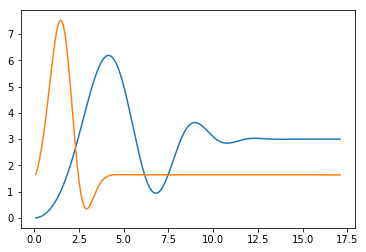

In [290]:
#plt.plot(g.x,(psi_gn[:,0].real / g.x ))
plt.plot(g.x,vext_g.real)
wfunc = 0
plt.plot(g.x,(psi_gn[:,wfunc].real)/(np.sqrt(np.pi)) + eps_n[wfunc].real )
#plt.plot(g.x,(psi_gn[:,wfunc].real)**2 + eps_n[wfunc].real )
#plt.plot(g.x,density.real)

#plt.plot([0,18],eps_n.real[1:],eps_n.real[1:])

#plt.xlim([0.5,6])
#plt.ylim([-1,8])

[1.64265968+0.09311304j 2.99851461-0.03434168j 3.0007353 -0.1430025j
 3.02457996-0.33125385j 3.09516132-0.5803222j  3.19798217-0.87861782j
 3.34921274-1.23353175j 3.50526874+0.07164564j 3.54887847-1.63301226j
 3.79638004-2.07969712j]


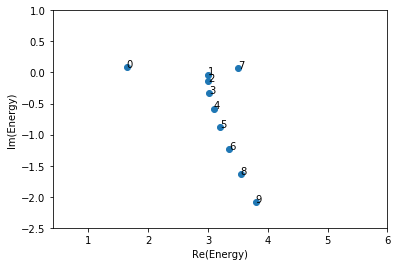

In [291]:
fig, ax = plt.subplots()
ax.scatter(eps_n.real, eps_n.imag)

plt.xlabel("Re(Energy)")
plt.ylabel("Im(Energy)")
plt.xlim([0.4,6])
plt.ylim([-2.5,1])
for i in range(0,nstates):
    ax.annotate(i, (eps_n[i].real, eps_n[i].imag))

print(eps_n)

In [292]:
#Grid 800, w=3
#theta = pi/12
#Bound state
#Kinetic (-56.20908386081614-1.509127922137525j)
#Potential (57.85631463964044+1.5552568982678843j)
#Total Energy (1.6472307788242944+0.04612897613035938j)
#Grid 2000 Total Energy (1.6710696280321997+0.05050797239715532j)
#Grid 2500 Total Energy (1.6741782317431557+0.05108944014990158j)




In [293]:
#Grid 800, w=3
#theta = 0
#Bound state
#Kinetic (-56.36078218811287-8.854228581379495e-20j)
#Potential (58.012143784126906+9.078564487147851e-20j)
#Total Energy (1.6513615960140342+2.24335905768356e-21j)

#Grid = 2000#Total Energy (1.6757403651526488+4.8115569986249415e-15j)
#Grid = 2500#Total Energy (1.6789216186059832-7.65779110912955e-14j)

#First resonance
#3.50768722+0.03437028j
#Second resonance
#4.42818355-0.37599265j

In [ ]:
#Grid 1000, w=3#
#theta=pi/6
#bound state
#Kinetic (-70.43993572297882-3.8248873124178044j)
#Potential (72.08259540048127+3.9180003569020383j)
#Total Energy (1.6426596775024507+0.09311304448423385j)
#first resonance
#3.50526874+0.07164564j

#Grid2000
#Kinetic (-143.80510961523112-8.271172158405014j)
#Potential (145.46250588324668+8.369908346064042j)
#Total Energy (1.6573962680155603+0.09873618765902847j)
#3.50526874+0.07164564j